# Parallelization and Complexity of Algorithms

The speed of a computational algorithm is in general dictated by two factors: the numerical algorithm that is used to compute something, and the speed of the microprocessor (dictated by clock time, or floating point operations per time, and the number of cores). To accelerate the code we have the following options:
- **choose an optimal algorithm**: optimal algorithm is the algorithm that needs the least computations to solve the problem.
- **Optimize the code**: in python for example can be achieved by avoiding loops and opting for vectorization instead. Also think about the data format and packages you are working with.
- **Machine Code**: Python is an interpreted language, meaning the code is executed line by line, which in machine terms can be very slow. Extending Python to Machine code (C++, C or Fortran using packages like `numba`, `jax`or `Cython`) comes in handy here!
- **Parallelisation**: Imagine a school group project where everyone does their part instead of one person having to do all of it on their own. Using multiple cores or GPUs we can carry out tasks in parallel.


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numba
from numba import njit, prange
import time

import jax
import jax.numpy as jnp
from jax.sharding import PartitionSpec as P

colour_prim = 'saddlebrown'
colour_sec = 'cornflowerblue'
colour_tert = 'mediumorchid'
colour_quad = 'forestgreen'

np.random.seed(420)

*The Example: N Body Interaction*


Consider a gravitational system of *N* massive bodies located at positions $\overrightarrow{X_i}$ (assumed to represent point masses with the same mass). The gravitational acceleration experienced by body *i* due to all other bodies is given by:

$$
 \overrightarrow{a_i} = - \sum_{j = 1, j \neq i}^N {\frac{(\overrightarrow{r_j} - \overrightarrow{r_i})}{|\overrightarrow{r_j} - \overrightarrow{r_i}|^3}}
$$

we want to calculate this acceleration for all bodies in the system. The exact algorithm to calculate the acceleration for all bodies to loop over all bodies and calculate the acceleration due to all other bodies, this algorithm has a complexity of $\mathcal{O}(\mathcal{N}^2)$: the time it takes to calculate the acceleration scales quadratically with the number of bodies.

In [46]:
def get_acceleration(X: np.ndarray) -> np.ndarray:
    """
    Computes the acceleration per particle via direct particle-particle computation. Brute force method, loops = bad.
    Complexity: N^2.

    Parameters
    ----------
    X : np.ndarray
        (N, 3) array of positions, N number of particles

    Returns
    -------
    np.ndarray
        (N, 3) array of accelerations
    """
    if type(X) != np.float64:
        N = len(X)
    else:
        N = X.shape[0]
    a = np.zeros(N)

    for i in range(N):
        for j in range(N):
            if i == j:
                pass
            else:
                a[i] = np.sum( (X[i,:] - X[j,:]) / np.abs((X[i,:] - X[j,:]))**3 )

    return a


def get_acceleration_vectorized(X: np.ndarray) -> np.ndarray:
    """
    Computes the acceleration per particle via direct particle-particle computation.
    Vectorized implementation with O(N^2) complexity but much faster execution.

    Parameters
    ----------
    X : np.ndarray
        (N, 3) array of positions, N number of particles

    Returns
    -------
    np.ndarray
        (N, 3) array of accelerations
    """
    N = X.shape[0]

    r_ij = X[:, np.newaxis, :] - X[np.newaxis, :, :]

    epsilon = 1e-10 # to avoid division by zero
    dist_cubed = np.sum(r_ij**2, axis=2, keepdims=True)**(3/2) + epsilon

    acc_contributions = r_ij / dist_cubed

    mask = ~np.eye(N, dtype=bool)[:, :, np.newaxis]
    a = np.sum(acc_contributions * mask, axis=1)

    return a

To test how slow these algorithms are we run them for different numbers of particles. If the implementation is correct they should show a complexity of $\mathcal{O}(\mathcal{N}^2)$.

In [47]:
def run(particles_list, compute_acceleration: callable = get_acceleration) -> np.ndarray:
    """
    Calculate the runtime for different number of particles (N) using the given acceleration function. """

    runtimes = np.zeros(len(particles_list))

    # run acceleration function for different number of particles (N)
    for i, N in enumerate(particles_list):
        start = time.time()

        # generate random positions for N particles and apply acceleration function
        X = np.random.randn(N, 3)
        acceleration = compute_acceleration(X)

        end = time.time()
        runtimes[i] = end - start
        print(f"{i+1}. Run with N = {N} done: {runtimes[i]:.6f} seconds")

    return runtimes, acceleration

def fit_runtime(X: np.ndarray, m: float, d: float) -> np.ndarray:
    yfit = d * np.power(X, m)
    return yfit

In [48]:
runs = 10
min_particles_log = 1
max_particles_log = 3
particles_list = np.logspace(min_particles_log, max_particles_log, runs, dtype= int)
xx_particles = np.logspace(min_particles_log, max_particles_log, 100)

print('Brute Force: Loops')
runtimes_bf, _ = run(particles_list, get_acceleration)

print('Vectorized')
runtimes_vec, _ = run(particles_list, get_acceleration_vectorized)

Brute Force: Loops
1. Run with N = 10 done: 0.000456 seconds
2. Run with N = 16 done: 0.001129 seconds
3. Run with N = 27 done: 0.004087 seconds
4. Run with N = 46 done: 0.008767 seconds
5. Run with N = 77 done: 0.016116 seconds
6. Run with N = 129 done: 0.048114 seconds
7. Run with N = 215 done: 0.128127 seconds
8. Run with N = 359 done: 0.364506 seconds
9. Run with N = 599 done: 1.005353 seconds
10. Run with N = 1000 done: 2.855834 seconds
Vectorized
1. Run with N = 10 done: 0.000093 seconds
2. Run with N = 16 done: 0.000165 seconds
3. Run with N = 27 done: 0.000044 seconds
4. Run with N = 46 done: 0.000101 seconds
5. Run with N = 77 done: 0.000226 seconds
6. Run with N = 129 done: 0.000603 seconds
7. Run with N = 215 done: 0.001533 seconds
8. Run with N = 359 done: 0.005090 seconds
9. Run with N = 599 done: 0.013682 seconds
10. Run with N = 1000 done: 0.041709 seconds


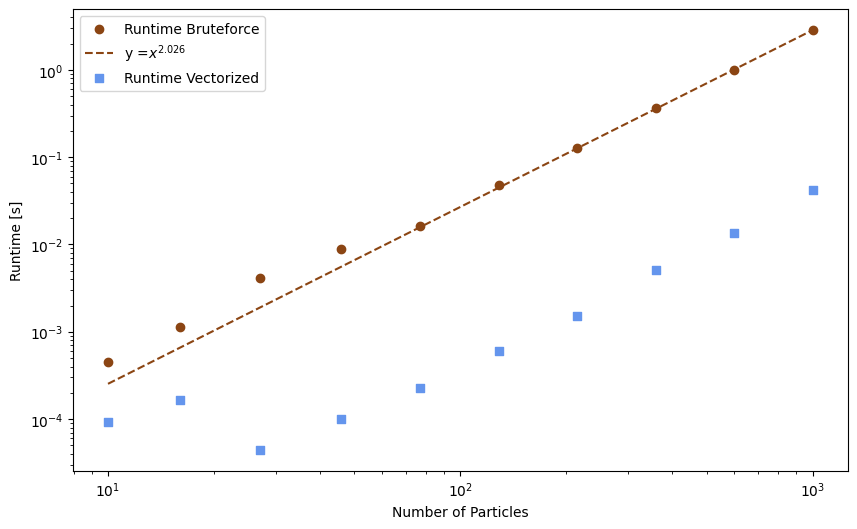

In [49]:
popt, pcov = curve_fit(fit_runtime, particles_list, runtimes_bf)
y_fit = fit_runtime(xx_particles, *popt)

def plot_runs():
    """
    Plot the runtime of the direct particle-particle computation and the fitted function.

    Returns
    -------
    matplotlib.figure.Figure
        matplotlib figure
    """
    fig = plt.figure(figsize=(10, 6))
    plt.scatter(particles_list, runtimes_bf, c = colour_prim, label = 'Runtime Bruteforce')
    plt.plot(xx_particles, y_fit, label=rf'y =$x^{{{popt[0]:.3f}}}$', c = colour_prim, ls = '--')
    plt.scatter(particles_list, runtimes_vec, c = colour_sec, marker = 's', label = 'Runtime Vectorized')


    plt.xlabel('Number of Particles')
    plt.ylabel('Runtime [s]')
    plt.legend()
    plt.loglog()

    return fig

fig1 = plot_runs()

Checks out! both show a complexity as we expected, the vectorized version takes less time to compute in general but also scales with $N^2$ with the number of particles.

#### Numba: Translating Python code to Machine Code
The numba njit decorator works best for numpy arrays and for loops. When a call is made to a njit decorated function, it is compiled (just-in-time) to machine code, so it can run at the speed of machine code! Note the runtime it takes for the first call, it is slower than the brute force method as compiling into machine code takes extra time

1. Run with N = 10 done: 0.103504 seconds
2. Run with N = 16 done: 0.000030 seconds
3. Run with N = 27 done: 0.000031 seconds
4. Run with N = 46 done: 0.000066 seconds
5. Run with N = 77 done: 0.000172 seconds
6. Run with N = 129 done: 0.000578 seconds
7. Run with N = 215 done: 0.001190 seconds
8. Run with N = 359 done: 0.003451 seconds
9. Run with N = 599 done: 0.009880 seconds
10. Run with N = 1000 done: 0.027347 seconds


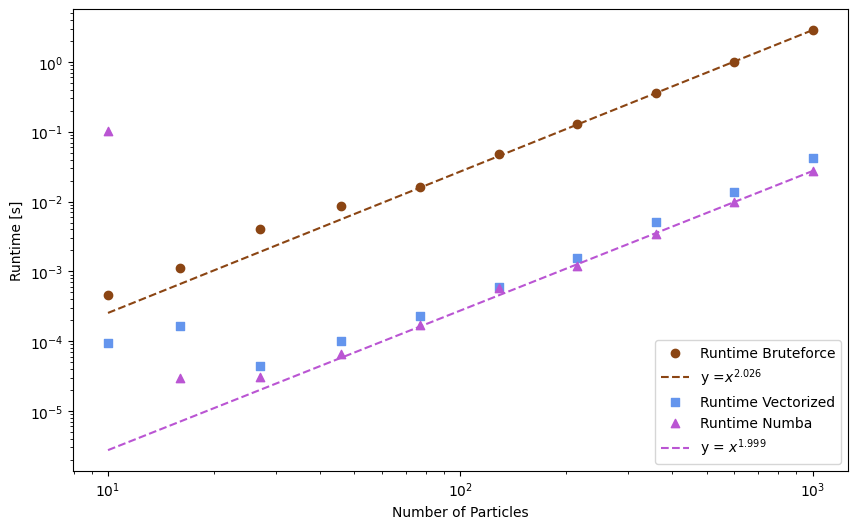

In [50]:
@njit
def get_acceleration_numba(X: np.ndarray) -> np.ndarray:
    """
    same function as above, but with the njit decorator for numba."""
    N = X.shape[0]
    a = np.zeros(N)

    for i in range(N):
        for j in range(N):
            if i == j:
                pass
            else:
                a[i] = np.sum( (X[i,:] - X[j,:]) / np.abs((X[i,:] - X[j,:]))**3 )

    return a

runtimes_numba, _ = run(particles_list, get_acceleration_numba)

popt_n, pcov_n = curve_fit(fit_runtime, particles_list[1:], runtimes_numba[1:])
y_fit_numba = fit_runtime(xx_particles, *popt_n)

fig1 = plot_runs()

plt.scatter(particles_list, runtimes_numba, c = colour_tert, marker = '^', label = 'Runtime Numba')
plt.plot(xx_particles, y_fit_numba, label=rf'y = $x^{{{popt_n[0]:.3f}}}$', c = colour_tert, ls = '--')
plt.legend()
plt.show()

#### Parallelisation with Numba

1. Run with N = 10 done: 0.239040 seconds
2. Run with N = 16 done: 0.000192 seconds
3. Run with N = 27 done: 0.000015 seconds
4. Run with N = 46 done: 0.000012 seconds
5. Run with N = 77 done: 0.000015 seconds
6. Run with N = 129 done: 0.000024 seconds
7. Run with N = 215 done: 0.000049 seconds
8. Run with N = 359 done: 0.000111 seconds
9. Run with N = 599 done: 0.000289 seconds
10. Run with N = 1000 done: 0.000802 seconds


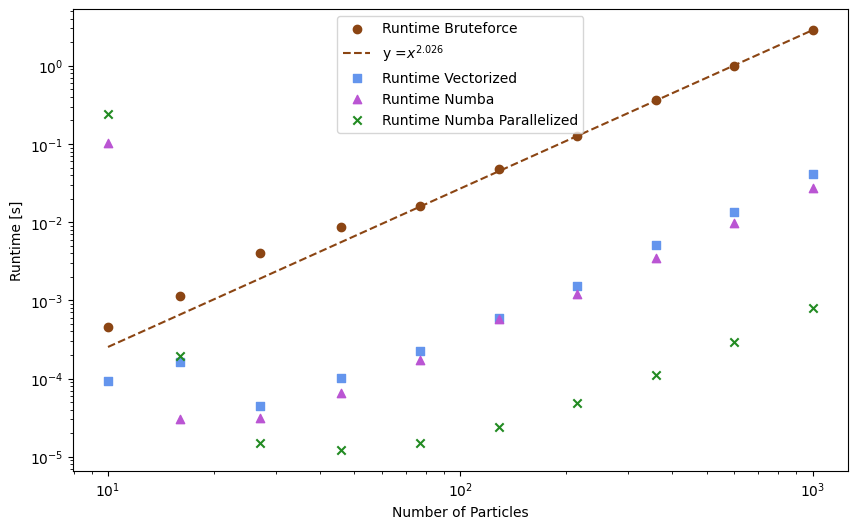

In [51]:
@njit(parallel = True)
def get_acceleration_numba_parallel(X: np.ndarray) -> np.ndarray:

    N = X.shape[0]
    a = np.zeros(N)
    for i in prange(N):
        for j in range(N):
            if i == j:
                pass
            else:
                a[i] = np.sum( (X[i,:] - X[j,:]) / np.abs((X[i,:] - X[j,:]))**3 )

    return a

runtimes_numba_parallel, _ = run(particles_list, get_acceleration_numba_parallel)



fig2 = plot_runs()

plt.scatter(particles_list, runtimes_numba, c = colour_tert, label = 'Runtime Numba', marker = '^')
plt.scatter(particles_list, runtimes_numba_parallel, c = colour_quad, label = 'Runtime Numba Parallelized', marker = 'x')

plt.legend()
plt.show()

#### Parallelisation using Jax
Single-Program Multi-Data (SPMD) code in JAX: same computation but executed on different input data (eg different batches). Key concept of parallel computation is data sharing, laying out the data on the available devices. JAX can understand how it should lay out the data with its in-built data structures (for example jax.Array). Every jax.Array has an associated jax.sharding.Sharding objects, which describes which shard of the global data is required by each global device, `jax.debug.visualize_array_sharding()` displays how the array is stored in memory of a single device.
To create an array with non-trivial sharding, one can define a `jax.sharding`application fo the array and pass this info to `jax.device_put()`

In [8]:
jax.devices() # check available devices

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [9]:
X = np.random.rand(1_000, 3)
X_jax = jax.numpy.asarray(X)

mesh = jax.make_mesh((8,), ('x',)) # mesh created based on how many devices we have
sharding = jax.sharding.NamedSharding(mesh, P('x')) # sharding = splitting up
X_sharded = jax.device_put(X_jax, sharding) # applying the sharding to the array, putting it on the different devices

jax.debug.visualize_array_sharding(X_sharded)

  TPU 0  
         
  TPU 1  
         
  TPU 2  
         
  TPU 3  
         
  TPU 6  
         
  TPU 7  
         
  TPU 4  
         
  TPU 5  
         

In [10]:
@jax.jit
def get_acceleration_JAX(X: jnp.ndarray) -> jnp.ndarray:
    # had to rewrite the og function because jax does not like numpy sometimes!

    N = X.shape[0]
    a = jnp.zeros_like(X)

    def comp_i(i, a_val):
        def comp_j(j, a_i):
            mask = i != j

            r_ij = X[i] - X[j]
            contribution = jnp.where(mask, r_ij / jnp.power(jnp.sum(r_ij**2), 1.5), 0.0)

            return a_i + contribution

        # for all j particles, loops in jax are weird
        a_i = jax.lax.fori_loop(0, N, comp_j, jnp.zeros(3)) # lower, upper, func, initial value

        return a_val.at[i].set(a_i)

    a = jax.lax.fori_loop(0, N, comp_i, a)

    return a

In [11]:
start = time.time()

acceleration = get_acceleration_JAX(X_sharded)

end = time.time()

print(f"Took {end-start:.5f} s to compute")

Took 0.14790 s to compute


In [14]:
runtimes_jax, _ = run(particles_list, get_acceleration_JAX)

1. Run with N = 10 done: 0.003109 seconds
2. Run with N = 16 done: 0.002666 seconds
3. Run with N = 27 done: 0.001691 seconds
4. Run with N = 46 done: 0.001925 seconds
5. Run with N = 77 done: 0.001610 seconds
6. Run with N = 129 done: 0.002537 seconds
7. Run with N = 215 done: 0.001853 seconds
8. Run with N = 359 done: 0.001543 seconds
9. Run with N = 599 done: 0.002701 seconds
10. Run with N = 1000 done: 0.002390 seconds
